# Individual mobility data in Greater Paris Region 

In [2]:
%load_ext autoreload
%autoreload 2
%cd D:\netmob25

D:\netmob25


In [3]:
# Load libs
import pandas as pd
import overturemaps
from shapely import wkb
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import time
from p_tqdm import p_map
import pickle
from datetime import timedelta
from math import ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import h3.api.numpy_int as h3
from shapely.geometry import Polygon
import openai
from openai import OpenAI
import yaml

In [3]:
with open('dbs/keys.yaml') as f:
    keys_manager = yaml.load(f, Loader=yaml.FullLoader)
openai.api_key = keys_manager['openai']['key']

## 1. Individual data

In [4]:
df_i = pd.read_csv('dbs/data/individuals_dataset.csv')
df_i.columns

Index(['ID', 'CODGEO', 'AREA_NAME', 'SEX', 'AGE', 'DIPLOMA', 'PRO_CAT',
       'TYPE_HOUSE', 'NBPERS_HOUSE', 'NB_10', 'NB_11_17', 'NB_18_24',
       'NB_25_64', 'NB_65', 'PMR', 'DRIVING_LICENCE', 'NB_CAR', 'TWO_WHEELER',
       'BIKE', 'ELECT_SCOOTER', 'NAVIGO_SUB', 'IMAGINER_SUB', 'OTHER_SUB_PT',
       'BIKE_SUB', 'NSM_SUB', 'WEIGHT_INDIV', 'GPS_RECORD'],
      dtype='object')

In [5]:
for var in ['ID', 'CODGEO', 'AREA_NAME', 'SEX', 'AGE', 'DIPLOMA', 'PRO_CAT',
       'TYPE_HOUSE', 'NBPERS_HOUSE']:
    print(f'{var} - {df_i[var].nunique()} unique values')
id_list = df_i.loc[df_i['GPS_RECORD'], 'ID'].values.tolist()
print(f'Individuals with GPS records: {len(id_list)}')

ID - 3337 unique values
CODGEO - 598 unique values
AREA_NAME - 587 unique values
SEX - 2 unique values
AGE - 66 unique values
DIPLOMA - 6 unique values
PRO_CAT - 8 unique values
TYPE_HOUSE - 8 unique values
NBPERS_HOUSE - 11 unique values
Individuals with GPS records: 3320


In [11]:
gdf = gpd.read_file('dbs/geo/paris_iris.geojson')
print(gdf['insee_com'].nunique())
gdf = pd.merge(df_i, gdf[['insee_com', 'geometry']], right_on='insee_com', left_on='CODGEO', how='left')
gdf.drop_duplicates('ID', inplace=True)

1286


In [12]:
len(gdf), gdf['insee_com'].nunique()

(3337, 598)

## 2. Trips

In [5]:
df_t = pd.read_csv('dbs/data/trips_dataset.csv')
df_t.columns

Index(['KEY', 'ID', 'Day_EMG', 'Date_EMG', 'Day_Type', 'ID_Trip_Days',
       'Type_Trip_OD', 'Area_O', 'Area_D', 'Code_INSEE_O', 'Code_INSEE_D',
       'Zone_O', 'Zone_D', 'Date_O', 'Time_O', 'Date_D', 'Time_D', 'Duration',
       'Purpose_O', 'Purpose_D', 'Main_Mode', 'Mode_1', 'Mode_2', 'Mode_3',
       'Mode_4', 'Mode_5', 'Weight_Day'],
      dtype='object')

In [6]:
df_it = df_t.groupby('ID')['Date_EMG'].nunique().sort_values(ascending=False).reset_index()
df_it.describe()

,Date_EMG
count,3337.000000
mean,7.002098
std,0.190438
min,5.000000
25%,7.000000
50%,7.000000
75%,7.000000
max,13.000000


## 3. Trajectories

In [36]:
id_sample = 67
df_sample = pd.read_csv(f'dbs/data/gps_dataset/{id_list[id_sample]}.csv')
df_sample.head()

,UTC DATETIME,LOCAL DATETIME,VALID,LATITUDE,LONGITUDE,SPEED
0,2023-03-13 08:12:01,2023-03-13 09:12:01,DGPS,48.836493,2.400697,2.378
1,2023-03-13 08:12:03,2023-03-13 09:12:03,DGPS,48.836493,2.400697,3.700
2,2023-03-13 08:12:05,2023-03-13 09:12:05,DGPS,48.836493,2.400697,2.228
3,2023-03-13 08:12:07,2023-03-13 09:12:07,DGPS,48.836493,2.400697,2.146
4,2023-03-13 08:12:09,2023-03-13 09:12:09,DGPS,48.836493,2.400697,2.509


In [8]:
df_t.loc[df_t['ID'] == id_list[id_sample], :]

,KEY,ID,Day_EMG,Date_EMG,Day_Type,ID_Trip_Days,Type_Trip_OD,Area_O,Area_D,Code_INSEE_O,...,Duration,Purpose_O,Purpose_D,Main_Mode,Mode_1,Mode_2,Mode_3,Mode_4,Mode_5,Weight_Day
37014,10_3067-monday-44998-1,10_3067,monday,2023-03-13,Normal,1,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75112,...,45.0,DEPART_HOME,WORK,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,115.454669
37015,10_3067-monday-44998-2,10_3067,monday,2023-03-13,Normal,2,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-12E-ARRONDISSEMENT,75117,...,34.0,WORK,PURCHASE,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,115.454669
37016,10_3067-monday-44998-3,10_3067,monday,2023-03-13,Normal,3,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75112,...,2.0,PURCHASE,RETURN_HOME,WALKING,WALKING,NaN,NaN,NaN,NaN,115.454669
37017,10_3067-tuesday-44999-1,10_3067,tuesday,2023-03-14,Normal,1,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75112,...,50.0,DEPART_HOME,WORK,SUBWAY,SUBWAY,BIKE,NaN,NaN,NaN,116.465617
37018,10_3067-tuesday-44999-2,10_3067,tuesday,2023-03-14,Normal,2,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75117,...,5.0,WORK,PURCHASE,WALKING,WALKING,NaN,NaN,NaN,NaN,116.465617
37019,10_3067-tuesday-44999-3,10_3067,tuesday,2023-03-14,Normal,3,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75117,...,5.0,PURCHASE,WORK,WALKING,WALKING,NaN,NaN,NaN,NaN,116.465617
37020,10_3067-tuesday-44999-4,10_3067,tuesday,2023-03-14,Normal,4,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-12E-ARRONDISSEMENT,75117,...,32.0,WORK,RETURN_HOME,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,116.465617
37021,10_3067-wednesday-45000-1,10_3067,wednesday,2023-03-15,Normal,1,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-12E-ARRONDISSEMENT,75112,...,2.0,DEPART_HOME,PURCHASE,WALKING,WALKING,NaN,NaN,NaN,NaN,112.432164
37022,10_3067-wednesday-45000-2,10_3067,wednesday,2023-03-15,Normal,2,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75112,...,46.0,PURCHASE,WORK,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,112.432164
37023,10_3067-wednesday-45000-3,10_3067,wednesday,2023-03-15,Normal,3,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75117,...,13.0,WORK,LEISURE,WALKING,WALKING,NaN,NaN,NaN,NaN,112.432164


In [31]:
def plot_trajectory(df):
    """
    Plot a trajectory in 2D.
    """

    # Create the figure and 3D axes
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot the 3D line or scatter
    plt.scatter(
        df['LONGITUDE'],
        df['LATITUDE'],
        c=df['time'].map(mdates.date2num),  # Optional: color by time
        cmap='viridis',
        s=10
    )

    # Label axes
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

## 4. Stays (h3-10) extractions
ID, time, longitude, latitude, activity_type, mode

After the below data exploration, the trajectories themselves are very scattered, i.e., missing points for subway for example. To extract stays, we use the trips_dataset.csv.

In [ ]:
# Ensure proper datetime format and sort
df_sample['time'] = pd.to_datetime(df_sample['LOCAL DATETIME'])
df_sample = df_sample.sort_values('time').reset_index(drop=True)

In [ ]:
# Define a threshold (e.g., 10 minutes) for detecting breaks
threshold = pd.Timedelta(minutes=10)

# Calculate time difference between consecutive rows
df_sample['time_diff'] = df_sample['time'].diff()

# Identify breaks: True if gap exceeds threshold
df_sample['new_trajectory'] = df_sample['time_diff'] > threshold

# Assign trajectory IDs by cumulative sum of breaks
df_sample['trajectory_id'] = df_sample['new_trajectory'].cumsum() + 1

# Drop helper columns if desired
df_sample.drop(columns=['time_diff', 'new_trajectory'], inplace=True)

# Get start and end timestamp of each trajectory
trajectory_summary = df_sample.groupby('trajectory_id')['time'].agg(['min', 'max']).reset_index()
trajectory_summary.columns = ['trajectory_id', 'start_time', 'end_time']

In [ ]:
trajectory_summary

In [ ]:
plot_trajectory(df=df_sample[df_sample['trajectory_id'].isin([1, 2, 3, 4, 5, 6])])

### 4.1 Consult trips_dataset.csv

In [41]:
df_t = df_t.loc[df_t['ID'] == id_list[id_sample], :]

In [42]:
# First ensure strings (if not already)
df_t['Date_O'] = df_t['Date_O'].astype(str)
df_t['Time_O'] = df_t['Time_O'].astype(str)
df_t['Date_D'] = df_t['Date_D'].astype(str)
df_t['Time_D'] = df_t['Time_D'].astype(str)

# Combine and convert to datetime
df_t['Time_O'] = pd.to_datetime(df_t['Date_O'] + ' ' + df_t['Time_O'])
df_t['Time_D'] = pd.to_datetime(df_t['Date_D'] + ' ' + df_t['Time_D'])

# Get unique trip id
df_t['trip_id'] = df_t['Date_EMG'].astype(str) + '_' + df_t['ID_Trip_Days'].astype(str)

In [56]:
# Set a tolerance window (e.g., 2 minutes)
epsilon = timedelta(minutes=1)

# Container for results
labeled_segments = []

# Iterate over trips
for idx, trip in df_t.iterrows():
    t_start = trip['Time_O'] - epsilon
    t_end = trip['Time_D'] + epsilon

    # Filter geolocation data within the window
    segment = df_sample[(df_sample['time'] >= t_start) & (df_sample['time'] <= t_end)].copy()
    segment['trip_id'] = df_t.loc[idx, 'trip_id']
    segment['duration'] = df_t.loc[idx, 'Duration']
    segment['weight_day'] = df_t.loc[idx, 'Weight_Day']
    segment['purpose_o'] = df_t.loc[idx, 'Purpose_O']
    segment['purpose_d'] = df_t.loc[idx, 'Purpose_D']
    segment['day_type'] = df_t.loc[idx, 'Day_Type']
    segment['dow'] = df_t.loc[idx, 'Day_EMG']
    labeled_segments.append(segment)

# Combine all labeled segments
df_with_trip_ids = pd.concat(labeled_segments).reset_index(drop=True)
df_with_trip_ids.head()

,UTC DATETIME,LOCAL DATETIME,VALID,LATITUDE,LONGITUDE,SPEED,time,trip_id,duration,weight_day,purpose_o,purpose_d,day_type,dow
0,2023-03-13 08:12:01,2023-03-13 09:12:01,DGPS,48.836493,2.400697,2.378,2023-03-13 09:12:01,2023-03-13_1,45.0,115.454669,DEPART_HOME,WORK,Normal,monday
1,2023-03-13 08:12:03,2023-03-13 09:12:03,DGPS,48.836493,2.400697,3.700,2023-03-13 09:12:03,2023-03-13_1,45.0,115.454669,DEPART_HOME,WORK,Normal,monday
2,2023-03-13 08:12:05,2023-03-13 09:12:05,DGPS,48.836493,2.400697,2.228,2023-03-13 09:12:05,2023-03-13_1,45.0,115.454669,DEPART_HOME,WORK,Normal,monday
3,2023-03-13 08:12:07,2023-03-13 09:12:07,DGPS,48.836493,2.400697,2.146,2023-03-13 09:12:07,2023-03-13_1,45.0,115.454669,DEPART_HOME,WORK,Normal,monday
4,2023-03-13 08:12:09,2023-03-13 09:12:09,DGPS,48.836493,2.400697,2.509,2023-03-13 09:12:09,2023-03-13_1,45.0,115.454669,DEPART_HOME,WORK,Normal,monday


In [ ]:
# Step 1: Aggregate base info including start and end times
trajectory_summary = df_with_trip_ids.groupby('trip_id').agg({
    'time': ['min', 'max'],
    'duration': 'first',
    'weight_day': 'first',
    'purpose_o': 'first',
    'purpose_d': 'first',
    'day_type': 'first',
    'dow': 'first'
}).reset_index()

# Flatten columns
trajectory_summary.columns = ['trip_id', 'start_time', 'end_time',
                              'duration', 'weight_day', 'purpose_o',
                              'purpose_d', 'day_type', 'dow']

# Step 2: Merge to get start lat/lon
start_coords = df_with_trip_ids.merge(
    trajectory_summary[['trip_id', 'start_time']],
    left_on=['trip_id', 'time'],
    right_on=['trip_id', 'start_time'],
    how='inner'
)[['trip_id', 'LATITUDE', 'LONGITUDE']].rename(columns={'LATITUDE': 'start_lat', 'LONGITUDE': 'start_lon'})

# Step 3: Merge to get end lat/lon
end_coords = df_with_trip_ids.merge(
    trajectory_summary[['trip_id', 'end_time']],
    left_on=['trip_id', 'time'],
    right_on=['trip_id', 'end_time'],
    how='inner'
)[['trip_id', 'LATITUDE', 'LONGITUDE']].rename(columns={'LATITUDE': 'end_lat', 'LONGITUDE': 'end_lon'})

# Step 4: Merge everything back
trajectory_summary = trajectory_summary.merge(start_coords, on='trip_id', how='left')
trajectory_summary = trajectory_summary.merge(end_coords, on='trip_id', how='left')

print(len(trajectory_summary), 'trajectories found vs. total trips', df_t['trip_id'].nunique())
missing_trajectories = [x for x in df_t['trip_id'].unique() if x not in trajectory_summary['trip_id'].unique()]
trajectory_summary

30 trajectories found vs. total trips 35


,trip_id,start_time,end_time,duration,weight_day,purpose_o,purpose_d,day_type,dow,start_lat,start_lon,end_lat,end_lon
0,2023-03-13_1,2023-03-13 09:12:01,2023-03-13 09:56:59,45.0,115.454669,DEPART_HOME,WORK,Normal,monday,48.836493,2.400697,48.878245,2.291730
1,2023-03-14_1,2023-03-14 08:59:01,2023-03-14 09:48:59,50.0,116.465617,DEPART_HOME,WORK,Normal,tuesday,48.836493,2.400697,48.878245,2.291730
2,2023-03-15_1,2023-03-15 09:07:01,2023-03-15 09:08:59,2.0,112.432164,DEPART_HOME,PURCHASE,Normal,wednesday,48.835686,2.399606,48.837299,2.401788
3,2023-03-15_2,2023-03-15 09:23:56,2023-03-15 09:54:15,46.0,112.432164,PURCHASE,WORK,Normal,wednesday,48.852301,2.366951,48.878245,2.291730
4,2023-03-15_3,2023-03-15 18:27:01,2023-03-15 18:40:00,13.0,112.432164,WORK,LEISURE,Normal,wednesday,48.881615,2.290156,48.887900,2.294566
5,2023-03-15_4,2023-03-15 20:00:00,2023-03-15 20:05:10,40.0,112.432164,LEISURE,PURCHASE,Normal,wednesday,48.888708,2.295658,48.885162,2.292907
6,2023-03-15_5,2023-03-15 20:45:00,2023-03-15 21:04:48,20.0,112.432164,PURCHASE,RETURN_HOME,Normal,wednesday,48.837933,2.398562,48.835686,2.399606
7,2023-03-16_1,2023-03-16 09:09:01,2023-03-16 09:50:00,41.0,113.673425,DEPART_HOME,PURCHASE,Normal,thursday,48.836493,2.400697,48.878245,2.291730
8,2023-03-16_2,2023-03-16 09:52:00,2023-03-16 09:54:00,2.0,113.673425,PURCHASE,WORK,Normal,thursday,48.879684,2.289588,48.879052,2.292822
9,2023-03-16_3,2023-03-16 18:08:00,2023-03-16 19:10:00,62.0,113.673425,WORK,OTHER,Normal,thursday,48.879368,2.291205,48.861256,2.352513


In [58]:
df_t[df_t['trip_id'].isin(missing_trajectories)]

,KEY,ID,Day_EMG,Date_EMG,Day_Type,ID_Trip_Days,Type_Trip_OD,Area_O,Area_D,Code_INSEE_O,...,Purpose_O,Purpose_D,Main_Mode,Mode_1,Mode_2,Mode_3,Mode_4,Mode_5,Weight_Day,trip_id
37015,10_3067-monday-44998-2,10_3067,monday,2023-03-13,Normal,2,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-12E-ARRONDISSEMENT,75117,...,WORK,PURCHASE,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,115.454669,2023-03-13_2
37016,10_3067-monday-44998-3,10_3067,monday,2023-03-13,Normal,3,Internal,PARIS-12E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75112,...,PURCHASE,RETURN_HOME,WALKING,WALKING,NaN,NaN,NaN,NaN,115.454669,2023-03-13_3
37018,10_3067-tuesday-44999-2,10_3067,tuesday,2023-03-14,Normal,2,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75117,...,WORK,PURCHASE,WALKING,WALKING,NaN,NaN,NaN,NaN,116.465617,2023-03-14_2
37019,10_3067-tuesday-44999-3,10_3067,tuesday,2023-03-14,Normal,3,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-17E-ARRONDISSEMENT,75117,...,PURCHASE,WORK,WALKING,WALKING,NaN,NaN,NaN,NaN,116.465617,2023-03-14_3
37020,10_3067-tuesday-44999-4,10_3067,tuesday,2023-03-14,Normal,4,Internal,PARIS-17E-ARRONDISSEMENT,PARIS-12E-ARRONDISSEMENT,75117,...,WORK,RETURN_HOME,SUBWAY,SUBWAY,NaN,NaN,NaN,NaN,116.465617,2023-03-14_4


### 4.2 Scale up the processing

In [61]:
def label_segments(df_target, df_trip, min_epsilon=1):
    """
    Label segments in df_sample with trip information from df_trip.
    """
    # Set a tolerance window (e.g., 2 minutes)
    epsilon = timedelta(minutes=1)

    # Container for results
    labeled_segments = []

    # Iterate over trips
    for idx, trip in df_trip.iterrows():
        t_start = trip['Time_O'] - epsilon
        t_end = trip['Time_D'] + epsilon

        # Filter geolocation data within the window
        segment = df_sample[(df_sample['time'] >= t_start) & (df_sample['time'] <= t_end)].copy()
        segment['trip_id'] = df_trip.loc[idx, 'trip_id']
        segment['duration'] = df_trip.loc[idx, 'Duration']
        segment['weight_day'] = df_trip.loc[idx, 'Weight_Day']
        segment['purpose_o'] = df_trip.loc[idx, 'Purpose_O']
        segment['purpose_d'] = df_trip.loc[idx, 'Purpose_D']
        segment['day_type'] = df_trip.loc[idx, 'Day_Type']
        segment['dow'] = df_trip.loc[idx, 'Day_EMG']
        labeled_segments.append(segment)

    # Combine all labeled segments
    df_with_trip_ids = pd.concat(labeled_segments).reset_index(drop=True)

    # Combine all labeled segments
    return df_with_trip_ids

def get_traj_summary(df_with_trip_ids, df_trip):
    # Step 1: Aggregate base info including start and end times
    trajectory_summary = df_with_trip_ids.groupby('trip_id').agg({
        'time': ['min', 'max'],
        'duration': 'first',
        'weight_day': 'first',
        'purpose_o': 'first',
        'purpose_d': 'first',
        'day_type': 'first',
        'dow': 'first'
    }).reset_index()

    # Flatten columns
    trajectory_summary.columns = ['trip_id', 'start_time', 'end_time',
                                'duration', 'weight_day', 'purpose_o',
                                'purpose_d', 'day_type', 'dow']

    # Step 2: Merge to get start lat/lon
    start_coords = df_with_trip_ids.merge(
        trajectory_summary[['trip_id', 'start_time']],
        left_on=['trip_id', 'time'],
        right_on=['trip_id', 'start_time'],
        how='inner'
    )[['trip_id', 'LATITUDE', 'LONGITUDE']].rename(columns={'LATITUDE': 'start_lat', 'LONGITUDE': 'start_lon'})

    # Step 3: Merge to get end lat/lon
    end_coords = df_with_trip_ids.merge(
        trajectory_summary[['trip_id', 'end_time']],
        left_on=['trip_id', 'time'],
        right_on=['trip_id', 'end_time'],
        how='inner'
    )[['trip_id', 'LATITUDE', 'LONGITUDE']].rename(columns={'LATITUDE': 'end_lat', 'LONGITUDE': 'end_lon'})

    # Step 4: Merge everything back
    trajectory_summary = trajectory_summary.merge(start_coords, on='trip_id', how='left')
    trajectory_summary = trajectory_summary.merge(end_coords, on='trip_id', how='left')

    # print(len(trajectory_summary), 'trajectories found vs. total trips', df_trip['trip_id'].nunique())
    missing_trajectories = [x for x in df_trip['trip_id'].unique() if x not in trajectory_summary['trip_id'].unique()]
    return trajectory_summary, df_trip[df_trip['trip_id'].isin(missing_trajectories)].copy()

In [59]:
df_t = pd.read_csv('dbs/data/trips_dataset.csv')
df_t.columns

Index(['KEY', 'ID', 'Day_EMG', 'Date_EMG', 'Day_Type', 'ID_Trip_Days',
       'Type_Trip_OD', 'Area_O', 'Area_D', 'Code_INSEE_O', 'Code_INSEE_D',
       'Zone_O', 'Zone_D', 'Date_O', 'Time_O', 'Date_D', 'Time_D', 'Duration',
       'Purpose_O', 'Purpose_D', 'Main_Mode', 'Mode_1', 'Mode_2', 'Mode_3',
       'Mode_4', 'Mode_5', 'Weight_Day'],
      dtype='object')

In [74]:
traj_batch_list = []
traj_summary_all = []
missing_trips_all = []

# Split into 20 roughly equal batches
batch_size = ceil(len(id_list) / 20)
batches = [id_list[i:i + batch_size] for i in range(0, len(id_list), batch_size)]

for b_idx, batch in enumerate(batches):
    traj_list = []
    traj_segments = []
    missing_trips_list = []

    for individual in tqdm(batch, desc=f"Processing Batch {b_idx + 1}"):
        df_sample = pd.read_csv(f'dbs/data/gps_dataset/{individual}.csv')
        df_sample['time'] = pd.to_datetime(df_sample['LOCAL DATETIME'])
        df_sample = df_sample.sort_values('time').reset_index(drop=True)

        df_ti = df_t.loc[(df_t['ID'] == individual) & (~df_t['Date_O'].isna()) & (~df_t['Date_D'].isna()) &\
            (~df_t['Time_O'].isna()) & (~df_t['Time_D'].isna()), :].copy()
        df_ti['Date_O'] = df_ti['Date_O'].astype(str)
        df_ti['Time_O'] = df_ti['Time_O'].astype(str)
        df_ti['Date_D'] = df_ti['Date_D'].astype(str)
        df_ti['Time_D'] = df_ti['Time_D'].astype(str)
        df_ti['Time_O'] = pd.to_datetime(df_ti['Date_O'] + ' ' + df_ti['Time_O'])
        df_ti['Time_D'] = pd.to_datetime(df_ti['Date_D'] + ' ' + df_ti['Time_D'])
        df_ti['trip_id'] = df_ti['Date_EMG'].astype(str) + '_' + df_ti['ID_Trip_Days'].astype(str)

        df_with_trip_ids = label_segments(df_target=df_sample, df_trip=df_ti, min_epsilon=1)
        trajectory_summary, missing_trips = get_traj_summary(df_with_trip_ids=df_with_trip_ids, df_trip=df_ti)

        trajectory_summary['ID'] = individual
        df_with_trip_ids['ID'] = individual

        traj_list.append(trajectory_summary)
        traj_segments.append(df_with_trip_ids)
        missing_trips_list.append(missing_trips)

    # Combine and save per batch
    batch_traj_summary = pd.concat(traj_list, ignore_index=True)
    batch_segments = pd.concat(traj_segments, ignore_index=True)
    batch_missing_trips = pd.concat(missing_trips_list, ignore_index=True)

    #batch_traj_summary.to_parquet(f'dbs/data/data_p/stays_extraction_batch_{b_idx+1}.parquet', index=False)
    batch_segments.to_parquet(f'dbs/data_p/gps_dataset/segments_batch_{b_idx+1}.parquet', index=False)
    #batch_missing_trips.to_parquet(f'dbs/data/data_p/missing_trips_batch_{b_idx+1}.parquet', index=False)

    # Optionally collect full set (if needed)
    traj_summary_all.append(batch_traj_summary)
    missing_trips_all.append(batch_missing_trips)

# Save overall summaries
full_trajectory_summary = pd.concat(traj_summary_all, ignore_index=True)
full_missing_trips = pd.concat(missing_trips_all, ignore_index=True)

full_trajectory_summary.to_parquet(f'dbs/data_p/stays_extraction_all.parquet', index=False)
full_missing_trips.to_parquet(f'dbs/data_p/trips_wo_traj_all.parquet', index=False)

Processing Batch 20: 100%|██████████| 166/166 [00:31<00:00,  5.26it/s]


### 4.3 Stays summary

In [69]:
# ---Step 1: get all unique coord pairs from the trajectory summary ---
full_trajectory_summary= pd.read_parquet(f'dbs/data_p/stays_extraction_all.parquet')

full_trajectory_summary.head()

,trip_id,start_time,end_time,duration,weight_day,purpose_o,purpose_d,day_type,dow,start_lat,start_lon,end_lat,end_lon,ID
0,2023-03-15_1,2023-03-15 16:40:01,2023-03-15 16:54:59,15.0,235.905683,DEPART_HOME,OTHER,Normal,wednesday,48.865031,2.139098,48.866024,2.144520,10_2978
1,2023-03-15_2,2023-03-15 17:00:00,2023-03-15 17:10:59,11.0,235.905683,OTHER,RETURN_HOME,Normal,wednesday,48.865527,2.141809,48.866651,2.141281,10_2978
2,2023-03-15_3,2023-03-15 17:36:00,2023-03-15 17:51:00,15.0,235.905683,DEPART_HOME,ACCOM,Normal,wednesday,48.866964,2.139661,48.819422,2.126685,10_2978
3,2023-03-15_4,2023-03-15 18:12:00,2023-03-15 18:26:00,14.0,235.905683,ACCOM,RETURN_HOME,Normal,wednesday,48.817488,2.126122,48.865031,2.139098,10_2978
4,2023-03-16_1,2023-03-16 08:12:00,2023-03-16 08:17:00,5.0,218.345882,DEPART_HOME,OTHER,Normal,thursday,48.866651,2.141281,48.866024,2.144520,10_2978


## 5. Auxiliary data
Geo-boundary, Overture POIs, and GTFS data.
### 5.1 Geo-boundary

<Axes: >

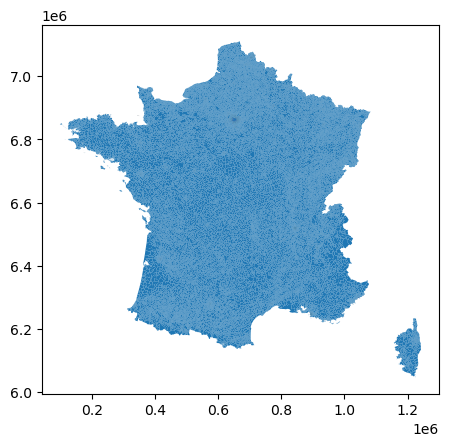

In [70]:
gdf = gpd.read_file('dbs/geo/iris/iris.shp')
gdf.plot()

In [71]:
gdf.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A,"POLYGON ((1052346.7 6848413, 1052502.3 6848474..."
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A,"MULTIPOLYGON (((891859 6248420, 891827 6248420..."
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A,"POLYGON ((219079.3 6760205.2, 219092.3 6760162..."
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A,"POLYGON ((657957.7 6866026.2, 658042.5 6866362..."
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A,"POLYGON ((666452.1 6849977.7, 666654.7 6850301..."


### 5.2 Overture POIs

In [8]:
# ---Step 1: get all unique coord pairs from the trajectory summary ---
full_trajectory_summary= pd.read_parquet(f'dbs/data_p/stays_extraction_all.parquet')
# Combine start and end coordinates into one DataFrame
start_coords = full_trajectory_summary[['start_lon', 'start_lat']].rename(columns={'start_lon': 'lon', 'start_lat': 'lat'})
end_coords = full_trajectory_summary[['end_lon', 'end_lat']].rename(columns={'end_lon': 'lon', 'end_lat': 'lat'})

# Concatenate and drop duplicates
unique_coords = pd.concat([start_coords, end_coords], ignore_index=True).drop_duplicates()

# Reset index for clarity
unique_coords = unique_coords.reset_index(drop=True)

# Get corresponding h3 id (10) for each coordinate pair
tqdm.pandas(desc="Calculating H3 IDs")
unique_coords['h3_id'] = unique_coords.progress_apply(lambda row: h3.latlng_to_cell(row['lat'], row['lon'], res=10), axis=1)

Calculating H3 IDs: 100%|██████████| 44296/44296 [00:00<00:00, 85560.63it/s] 


In [ ]:
# ---Step 2: Create a GeoDataFrame with H3 IDs ---
# Extract unique h3_ids
h3_list = unique_coords['h3_id'].unique().tolist()
polygons = [Polygon(h3.cells_to_geo([x])['coordinates'][0]) for x in h3_list]

# Create a GeoDataFrame from unique h3_ids
gdf_h3 = gpd.GeoDataFrame(
    h3_list,
    geometry=polygons,
    crs="EPSG:4326"
)
gdf_h3.columns= ['h3_id', 'geometry']
gdf_h3.to_file('dbs/geo/h3_10.gpkg', driver='GPKG', layer='h3_10')

In [10]:
# ---Step 3: Download the POIs ---
# Get the bounding box of the GeoDataFrame
minx, miny, maxx, maxy = gdf_h3.total_bounds
bbox = (minx, miny, maxx, maxy)
print(f"Bounding box: {bbox}")

# Download POIs from Overture Maps
# columns=['id', 'source', 'geometry', "class", "subtype"]
table = overturemaps.record_batch_reader("place", bbox).read_all()
table = table.combine_chunks()

# convert to dataframe
df_poi = table.to_pandas()

# DataFrame to GeoDataFrame, set crs
gdf_poi = gpd.GeoDataFrame(
    df_poi,
    geometry=df_poi['geometry'].apply(wkb.loads),
    crs="EPSG:4326"
)

# Process POIs
gdf_poi = gdf_poi[['id', 'geometry', 'sources', 'categories', 'confidence']]
gdf_poi.loc[:, 'source'] = gdf_poi['sources'].apply(lambda x: x[0]['dataset'])
print("Before removing the ones w/o categories", len(gdf_poi))
gdf_poi.dropna(subset=['categories'], inplace=True)
print("No. of places", len(gdf_poi))

# Process to get primary and secondary categories
gdf_poi.loc[:, 'primary'] = gdf_poi['categories'].apply(lambda x: x['primary'])
gdf_poi.loc[:, 'secondary'] = gdf_poi['categories'].apply(lambda x: list(x['alternate']) if (x['alternate'] is not None) else None)
gdf_poi = gdf_poi[['id', 'geometry', 'source', 'primary', 'secondary', 'confidence']]
gdf_poi.loc[:, 'secondary'] = gdf_poi.apply(lambda row: [row['primary']] if row['secondary'] is None else row['secondary'], axis=1)
gdf_poi.head()

Bounding box: (0.02871641290605309, 43.09307132567957, 7.757027315355986, 52.482385644076615)
Before removing the ones w/o categories 3018463
No. of places 2852016


,id,geometry,source,primary,secondary,confidence
1,08f396645278d21103865a71b0149a12,POINT (0.03067 43.10657),meta,farmers_market,[farmers_market],0.275468
2,08f39664526034000351dad4f8251283,POINT (0.03299 43.10662),meta,bed_and_breakfast,"[tours, travel]",0.953741
3,08f396645002c005034e1bd2030a4ac2,POINT (0.03988 43.13663),meta,shopping,[shopping],0.251852
5,08f396645088574d037e9bb4d665fcc3,POINT (0.03444 43.14077),meta,art_gallery,[sculpture_statue],0.953741
6,08f3966450175ad3038c0e5b357c3d58,POINT (0.03958 43.13902),meta,arts_and_crafts,[arts_and_crafts],0.251852


#### 5.2.1 POIs characteristics
##### Labels

<Axes: ylabel='primary'>

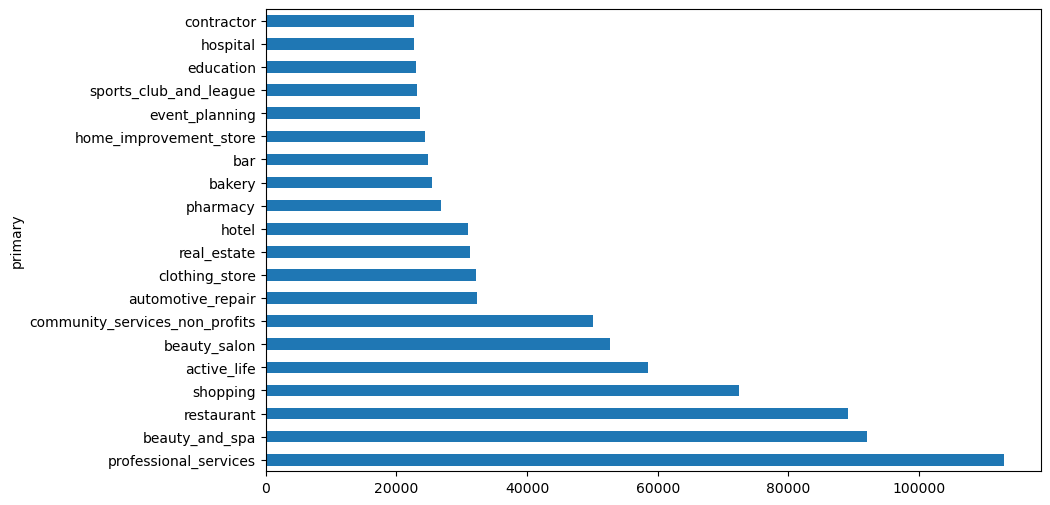

In [11]:
gdf_poi['primary'].value_counts().head(20).plot(kind='barh', figsize=(10, 6))

In [ ]:
gdf_poi['primary'].unique()

1793

##### Confidence level
Based on the below exploration, we keep POIs with confidence level above 0.7.

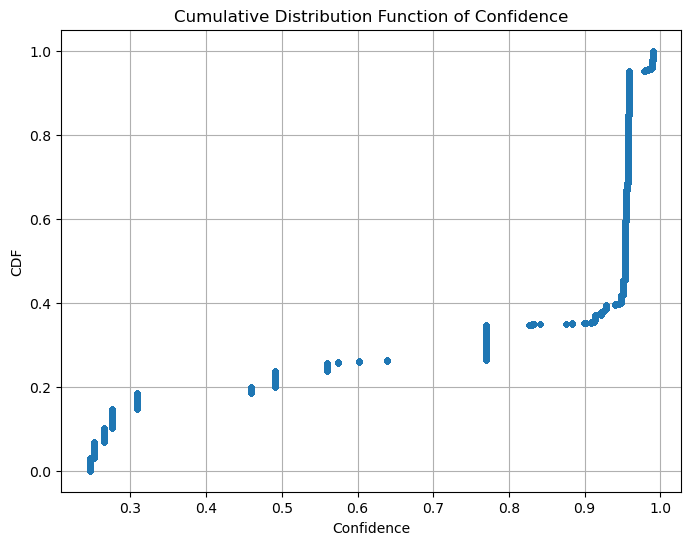

In [13]:
# Sort the confidence values
sorted_conf = np.sort(gdf_poi['confidence'].dropna())

# Calculate CDF values
cdf = np.arange(1, len(sorted_conf)+1) / len(sorted_conf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sorted_conf, cdf, marker='.', linestyle='none')
plt.xlabel('Confidence')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Confidence')
plt.grid(True)
plt.show()

#### 5.2.2 POIs categorization

In [15]:
gdf_poi = gdf_poi[gdf_poi['confidence'] > 0.7].reset_index(drop=True)
print("No. of places", len(gdf_poi), "No. of primary categories", gdf_poi['primary'].nunique())

No. of places 2098361 No. of primary categories 1784


In [39]:
# Count frequency of each category
poi_freq = gdf_poi['primary'].value_counts()

# Compute cumulative sum of counts
cum_counts = poi_freq.cumsum()

# Compute cumulative percentage
cum_percent = cum_counts / poi_freq.sum() * 100

# Optional: Combine into a DataFrame for inspection
poi_cdf = pd.DataFrame({
    'count': poi_freq,
    'cumulative_count': cum_counts,
    'cumulative_percent': cum_percent
}).reset_index().rename(columns={'index': 'primary'})

print(poi_cdf[poi_cdf['count'] > 9])

                    primary  count  cumulative_count  cumulative_percent
0     professional_services  79468             79468            3.787146
1                restaurant  70266            149734            7.135760
2            beauty_and_spa  66047            215781           10.283312
3                  shopping  43384            259165           12.350830
4              beauty_salon  40314            299479           14.272044
...                     ...    ...               ...                 ...
1402      children's_museum     10           2096831           99.927086
1403      livestock_dealers     10           2096841           99.927563
1404          ferry_service     10           2096851           99.928039
1405                  mills     10           2096861           99.928516
1406              dive_shop     10           2096871           99.928992

[1407 rows x 4 columns]


In [40]:
categories_str = "\n".join(['Essential needs', 'Health services', 'Education', 'Civic and utility', 'Social & Leisure', 'Other'])

In [ ]:
client = openai.OpenAI()

models = client.models.list()

for model in models.data:
    print(model.id)

In [47]:
client = OpenAI()  # This assumes you have OPENAI_API_KEY set in your environment

def poi_category(x, categories_str):
    flag = 0
    while flag != 1:
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "system",
                        "content": (
                            "You will be presented with points of interest primary labels from Overture and your job is to "
                            "provide the most suitable parental tag from the following list. Choose ONLY from the list of tags provided here:\n\n"
                            f"{categories_str}"
                        )
                    },
                    {
                        "role": "user",
                        "content": x
                    }
                ],
                temperature=0,
                max_tokens=1024,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0
            )
            flag = 1
            return response.choices[0].message.content.strip()
        except Exception as e:
            print("Error:", e)
            time.sleep(2)

In [49]:
tqdm.pandas(desc="Categorizing POIs")
poi_cdf['tag'] = poi_cdf['primary'].progress_apply(lambda x: poi_category(x, categories_str))

Categorizing POIs: 100%|██████████| 1784/1784 [17:45<00:00,  1.67it/s]


In [52]:
poi_cdf.to_csv('results/poi_categories.csv', index=False)

#### 5.2.3 Check categories
This is done manually.

In [57]:
poi_cdf = pd.read_csv('results/poi_categories_r.csv')
poi_cdf.loc[:, 'tag'] = poi_cdf.apply(lambda row: 'Restaurant' if 'restaurant' in row['primary'] else row['tag'], axis=1)
poi_cdf.head()

,primary,count,cumulative_count,cumulative_percent,tag
0,professional_services,79468,79468,3.787146,Civic and utility
1,restaurant,70266,149734,7.135760,Restaurant
2,beauty_and_spa,66047,215781,10.283312,Social & Leisure
3,shopping,43384,259165,12.350830,Essential needs
4,beauty_salon,40314,299479,14.272044,Social & Leisure


<Axes: ylabel='tag'>

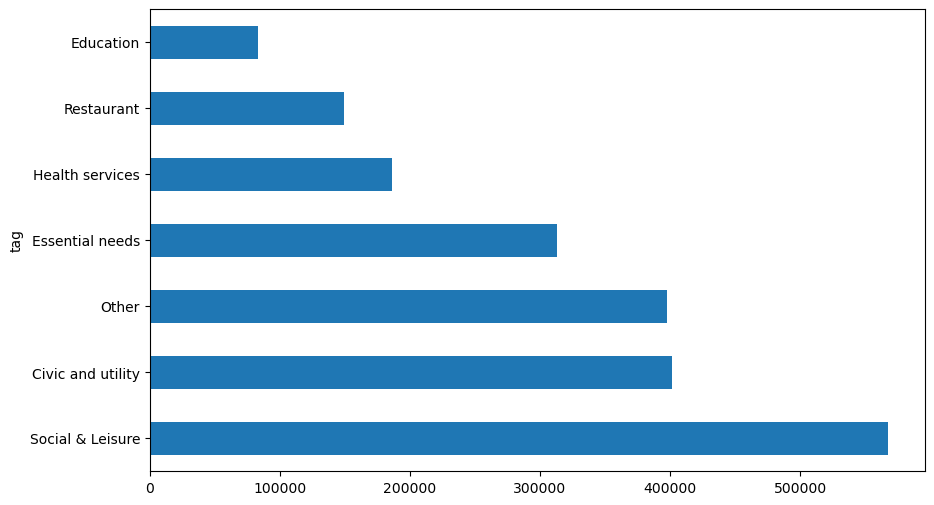

In [58]:
poi_cdf.groupby('tag')['count'].sum().sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6))

In [59]:
poi_cdf.to_csv('results/poi_categories_final.csv', index=False)

In [6]:
poi_cdf = pd.read_csv('results/poi_categories_final.csv')
poi_cdf.groupby('tag')['count'].sum()/1000

tag
Civic and utility    401.592
Education             83.581
Essential needs      312.956
Health services      186.240
Other                397.366
Restaurant           149.113
Social & Leisure     567.513
Name: count, dtype: float64

### 5.3 GTFS data
It was downloaded from [here](https://transport.data.gouv.fr/datasets/reseau-urbain-et-interurbain-dile-de-france-mobilites).

In [15]:
df_stops = pd.read_csv('dbs/geo/IDFM-gtfs/stops.txt', delimiter=',')
print("No. of stops", len(df_stops))
df_stops.head()

No. of stops 53519


,stop_id,stop_code,stop_name,stop_desc,stop_lon,stop_lat,zone_id,stop_url,location_type,parent_station,stop_timezone,level_id,wheelchair_boarding,platform_code
0,IDFM:monomodalStopPlace:58498,NaN,Rosa Parks,NaN,2.373718,48.896458,1.0,NaN,0,IDFM:73798,NaN,NaN,1,NaN
1,IDFM:monomodalStopPlace:415484,NaN,Égly,NaN,2.223463,48.582716,5.0,NaN,0,IDFM:60052,NaN,NaN,0,NaN
2,IDFM:monomodalStopPlace:464040,NaN,Le Vert de Maisons,NaN,2.432124,48.788831,3.0,NaN,0,IDFM:73624,NaN,NaN,1,NaN
3,IDFM:monomodalStopPlace:473875,NaN,Nation,NaN,2.395944,48.848233,1.0,NaN,0,IDFM:71673,NaN,NaN,1,NaN
4,IDFM:monomodalStopPlace:53783,NaN,Chatou - Croissy,NaN,2.155938,48.885197,4.0,NaN,0,IDFM:64483,NaN,NaN,1,NaN


## 6. Save POI data with tags

In [64]:
poi_cdf['tag'].unique()

array(['Civic and utility', 'Restaurant', 'Social & Leisure',
       'Essential needs', 'Other', 'Health services', 'Education'],
      dtype=object)

In [61]:
gdf_poi = pd.merge(gdf_poi, poi_cdf[['primary', 'tag']], how='left', on='primary')
gdf_poi.head()

,id,geometry,source,primary,secondary,confidence,tag
0,08f39664526034000351dad4f8251283,POINT (0.03299 43.10662),meta,bed_and_breakfast,"[tours, travel]",0.953741,Essential needs
1,08f396645088574d037e9bb4d665fcc3,POINT (0.03444 43.14077),meta,art_gallery,[sculpture_statue],0.953741,Social & Leisure
2,08f396645340a52d0352208228386dd4,POINT (0.0515 43.11061),meta,farm,[fruits_and_vegetables],0.948077,Other
3,08f39664534598610361c1411eea266d,POINT (0.05538 43.11075),meta,bar,[farmers_market],0.954320,Social & Leisure
4,08f396645ed9a4b4038533a3f3bfaeba,POINT (0.07098 43.11994),meta,real_estate_agent,"[real_estate, photography_museum]",0.953741,Other


In [63]:
gdf_poi.to_file('dbs/geo/pois.gpkg', driver='GPKG', layer='pois')